# Classificação de Churn com Árvores de Decisão

**Objetivo:**  
Usar o dataset Telco Customer Churn para prever se um cliente vai cancelar (`Churn`) usando modelos de classificação.  
O notebook vai comparar três modelos:
- Árvores de Decisão
- KNN
- Regressão Logística

Também vamos fazer:
- Ajuste de hiperparâmetros usando Grid Search
- Poda da árvore usando `ccp_alpha` para melhorar generalização

---

## Features (variáveis)

O dataset contém as seguintes colunas:
- `customerID`: Identificador único do cliente
- `gender`: Gênero do cliente
- `SeniorCitizen`: Se é idoso (1) ou não (0)
- `Partner`: Se tem parceiro(a)
- `Dependents`: Se tem dependentes
- `tenure`: Meses como cliente
- `PhoneService`: Se possui serviço telefônico
- `MultipleLines`: Se possui múltiplas linhas
- `InternetService`: Tipo de serviço de internet
- `OnlineSecurity`: Se possui segurança online
- `DeviceProtection`: Se possui proteção de dispositivo
- `TechSupport`: Se possui suporte técnico
- `StreamingTV`: Se usa streaming de TV
- `StreamingMovies`: Se usa streaming de filmes
- `Contract`: Tipo de contrato (mensal, anual, etc.)
- `PaperlessBilling`: Se usa fatura digital
- `PaymentMethod`: Método de pagamento
- `MonthlyCharges`: Valor mensal cobrado
- `TotalCharges`: Total gasto até agora
- `Churn`: **Alvo** (se o cliente cancelou ou não)

---


In [ ]:
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [2]:
# 1. Carregar o dataset (via seaborn)

path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)
df = pd.read_csv(f"{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df = df.dropna()  # remover linhas com valores nulos
print(len(df))
df.head(3)

Path to dataset files: /home/lecraizer/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1
7043


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [3]:
# 2. Separar X e y
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
y = df['Churn']

X = df.drop(columns=['Churn'])

# 3. Codificar variáveis categóricas
cat_cols = X.select_dtypes(include='object').columns

X_encoded = X.copy()
for col in cat_cols:
    X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col].astype(str))

In [4]:
# 4. Treino/Teste e normalização
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Treinar modelos
model_dt = DecisionTreeClassifier(random_state=42)
model_knn = KNeighborsClassifier()
model_lr = LogisticRegression(max_iter=1000)

# 6. Validação cruzada (5-fold)
scores_dt_acc = cross_val_score(model_dt, X_train_scaled, y_train, cv=5, scoring='accuracy')
scores_knn_acc = cross_val_score(model_knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
scores_lr_acc = cross_val_score(model_lr, X_train_scaled, y_train, cv=5, scoring='accuracy')

scores_dt_f1 = cross_val_score(model_dt, X_train_scaled, y_train, cv=5, scoring='f1')
scores_knn_f1 = cross_val_score(model_knn, X_train_scaled, y_train, cv=5, scoring='f1')
scores_lr_f1 = cross_val_score(model_lr, X_train_scaled, y_train, cv=5, scoring='f1')

In [5]:
# 7. Resultados comparativos
results = pd.DataFrame({
    'Modelo': ['Árvore de Decisão', 'KNN', 'Regressão Logística'],
    'Acurácia Média': [scores_dt_acc.mean(), scores_knn_acc.mean(), scores_lr_acc.mean()],
    'F1-Score Médio': [scores_dt_f1.mean(), scores_knn_f1.mean(), scores_lr_f1.mean()]
})

print("Resultados com validação cruzada (5-fold):")
display(results.round(4))

Resultados com validação cruzada (5-fold):


,Modelo,Acurácia Média,F1-Score Médio
0,Árvore de Decisão,0.7291,0.5003
1,KNN,0.7584,0.5245
2,Regressão Logística,0.8035,0.5905


### Grid search

In [6]:
# Definir a grade de hiperparâmetros
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Criar e executar o GridSearch
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)
best_tree = grid_search.best_estimator_

# Avaliar no conjunto de teste
y_pred_grid = best_tree.predict(X_test_scaled)
print("Melhores parâmetros:", grid_search.best_params_)
print("Acurácia (teste):", round(accuracy_score(y_test, y_pred_grid), 4))
print("F1-score (teste):", round(f1_score(y_test, y_pred_grid), 4))


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Melhores parâmetros: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
Acurácia (teste): 0.78
F1-score (teste): 0.591


### Pruning com CCR Alpha

In [7]:
# Gerar caminho de pruning
path = best_tree.cost_complexity_pruning_path(X_train_scaled, y_train)
ccp_alphas = path.ccp_alphas[:-1]  # remover último (gera uma árvore vazia)

# Treinar uma árvore para cada alpha
trees = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, **grid_search.best_params_, ccp_alpha=alpha)
    clf.fit(X_train_scaled, y_train)
    trees.append(clf)

# Avaliar com validação cruzada
val_scores = [cross_val_score(clf, X_train_scaled, y_train, cv=5, scoring='f1').mean() for clf in trees]

# Melhor alpha
best_index = np.argmax(val_scores)
best_alpha = ccp_alphas[best_index]
print(f"Melhor ccp_alpha encontrado: {best_alpha}")

# Modelo final com pruning
pruned_tree = DecisionTreeClassifier(random_state=42, **grid_search.best_params_, ccp_alpha=best_alpha)
pruned_tree.fit(X_train_scaled, y_train)
y_pred_pruned = pruned_tree.predict(X_test_scaled)

print("Árvore com pruning:")
print("Acurácia (teste):", round(accuracy_score(y_test, y_pred_pruned), 4))
print("F1-score (teste):", round(f1_score(y_test, y_pred_pruned), 4))

Melhor ccp_alpha encontrado: 0.0010322504372259275
Árvore com pruning:
Acurácia (teste): 0.7807
F1-score (teste): 0.5918


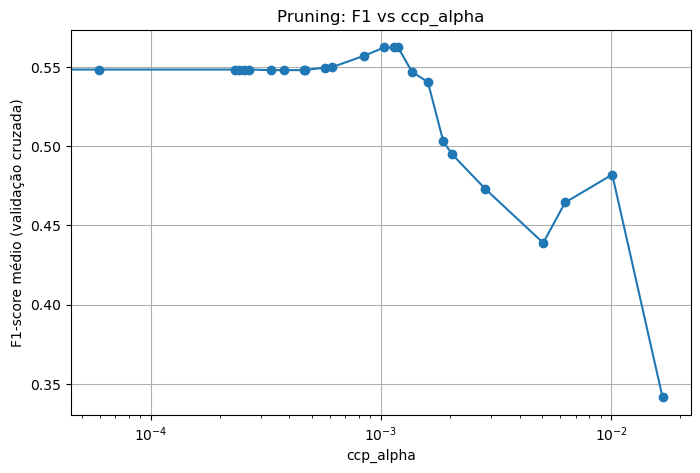

In [8]:
plt.figure(figsize=(8,5))
plt.plot(ccp_alphas, val_scores, marker='o')
plt.xlabel('ccp_alpha')
plt.ylabel('F1-score médio (validação cruzada)')
plt.title('Pruning: F1 vs ccp_alpha')
plt.xscale('log')
plt.grid()
plt.show()